In [3]:
import geopandas as gpd

COUNTRY_TAGS = [
        'boundary',
        'admin_level',
        'ISO3166-1',
        #'ISO3166-1:alpha2',
        'ISO3166-1:alpha3',
        'ISO3166-1:numeric',
        #'ISO3166-2',
        'name:en',
        'name',
        'alt_name',
        'wikidata',
        'wikipedia',
        'geometry',
]

gdf = gpd.read_file('temp/country-borders-raw.geo.jsonseq', engine="pyogrio", columns=COUNTRY_TAGS)
gdf

,ISO3166-1,ISO3166-1:alpha3,ISO3166-1:numeric,ISO3166-2,admin_level,alt_name,boundary,name,name:en,wikidata,wikipedia,geometry
0,None,None,None,None,2,None,administrative,None,None,None,None,"LINESTRING (14.82335 50.87057, 14.82273 50.870..."
1,None,None,None,None,2,None,administrative,None,None,None,None,"LINESTRING (14.85040 50.90941, 14.85062 50.909..."
2,None,None,None,None,2,None,administrative,None,None,None,None,"LINESTRING (14.87458 50.92852, 14.87486 50.929..."
3,None,None,None,None,2,None,administrative,None,None,None,None,"LINESTRING (11.67591 58.93513, 11.67586 58.935..."
4,None,None,None,None,2,None,administrative,Tanzania - Malawi,None,None,None,"LINESTRING (34.70646 -11.18058, 34.70657 -11.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...
34637,TM,TKM,795,None,2,None,administrative,Türkmenistan,Turkmenistan,Q874,en:Turkmenistan,"MULTIPOLYGON (((52.26435 41.61197, 52.26723 41..."
34638,IR,IRN,364,None,2,None,administrative,ایران,Iran,Q794,fa:ایران,"MULTIPOLYGON (((44.03189 39.37173, 44.03205 39..."
34639,None,None,None,None,2,None,administrative,Italia - Slovenija,Italy - Slovenia,None,None,"LINESTRING (13.59112 45.88809, 13.59088 45.887..."
34640,SI,SVN,705,None,2,None,administrative,Slovenija,Slovenia,Q215,sl:Slovenija,"MULTIPOLYGON (((13.37547 46.29770, 13.37584 46..."


<Axes: >

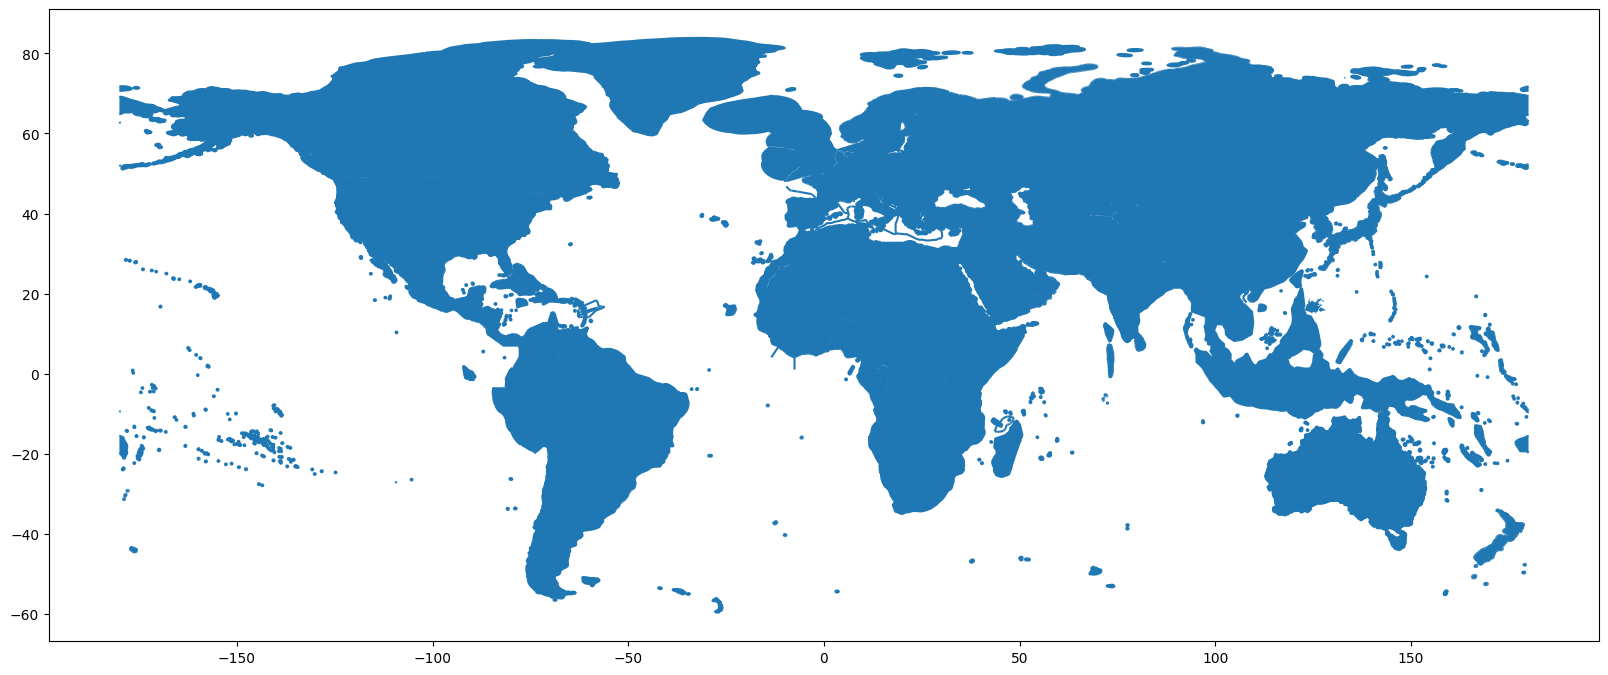

In [2]:
gdf.plot(figsize=(20,20))

In [3]:
for c in gdf.columns:
    if ':' in c:
        continue
    print(f"        '{c}',")

        'CEMT',
        'FIXME',
        'ISO3166-1',
        'ISO3166-2',
        'access',
        'admin_level',
        'alt_int_name',
        'alt_name',
        'alt_name2',
        'alt_name_1',
        'alt_name_2',
        'alt_official_name',
        'amenity',
        'architect',
        'area',
        'arete',
        'artwork_type',
        'attraction',
        'attribution',
        'authoritative',
        'barrier',
        'bezier',
        'bicycle',
        'boat',
        'border_status',
        'border_type',
        'boundary',
        'boundary_1',
        'boundary_type',
        'branch',
        'brand',
        'bridge',
        'building',
        'canoe',
        'capital',
        'capital_city',
        'carriageway',
        'carriageway_ref',
        'city',
        'claim_level',
        'claimed_by',
        'clcfile',
        'clctype',
        'code',
        'comment',
        'construction',
        'controlled_by',
        'country',
       

In [4]:
countries = gdf[COUNTRY_TAGS].dropna(subset='name').dropna(subset='ISO3166-1')
countries

,boundary,admin_level,ISO3166-1,ISO3166-1:alpha3,ISO3166-1:numeric,ISO3166-2,name:en,name,alt_name,wikidata,wikipedia,geometry
6624,administrative,2,BB,BRB,052,None,Barbados,Barbados,None,Q244,en:Barbados,"MULTIPOLYGON (((-59.85621 13.30800, -59.85618 ..."
6626,administrative,2,JM,JAM,388,None,Jamaica,Jamaica,None,Q766,en:Jamaica,"MULTIPOLYGON (((-78.57824 18.26905, -78.57680 ..."
6645,administrative,2,NR,NRU,520,None,Nauru,Naoero,None,Q697,en:Nauru,"MULTIPOLYGON (((166.70999 -0.53400, 166.71007 ..."
18574,administrative,2,IM,IMN,833,None,Isle of Man,Isle of Man,None,Q9676,en:Isle of Man,"MULTIPOLYGON (((-5.17073 54.05400, -5.17072 54..."
18615,administrative,2,SH,SHN,654,None,"Saint Helena, Ascension and Tristan da Cunha","Saint Helena, Ascension and Tristan da Cunha",None,Q192184,"en:Saint Helena, Ascension and Tristan da Cunha","MULTIPOLYGON (((-14.62269 -7.94100, -14.62264 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
34635,administrative,2,US,USA,840,None,United States,United States,None,Q30,en:United States,"MULTIPOLYGON (((-180.00000 51.79409, -179.9926..."
34637,administrative,2,TM,TKM,795,None,Turkmenistan,Türkmenistan,None,Q874,en:Turkmenistan,"MULTIPOLYGON (((52.26435 41.61197, 52.26723 41..."
34638,administrative,2,IR,IRN,364,None,Iran,ایران,None,Q794,fa:ایران,"MULTIPOLYGON (((44.03189 39.37173, 44.03205 39..."
34640,administrative,2,SI,SVN,705,None,Slovenia,Slovenija,None,Q215,sl:Slovenija,"MULTIPOLYGON (((13.37547 46.29770, 13.37584 46..."


In [7]:
countries_tsv = countries.drop(columns=['boundary','admin_level', 'ISO3166-2', 'geometry']).sort_values(by='ISO3166-1')
countries_tsv.to_csv('countries.tsv', encoding='utf8', sep='\t', index=None)
countries_tsv

,ISO3166-1,ISO3166-1:alpha3,ISO3166-1:numeric,name:en,name,alt_name,wikidata,wikipedia
28846,AD,AND,020,Andorra,Andorra,None,Q228,ca:Andorra
32107,AE,ARE,784,United Arab Emirates,الإمارات العربية المتحدة,None,Q878,ar:الإمارات العربية المتحدة
34593,AF,AFG,004,Afghanistan,افغانستان,None,Q889,ps:افغانستان
31337,AG,ATG,028,Antigua and Barbuda,Antigua and Barbuda,None,Q781,en:Antigua and Barbuda
28795,AI,AIA,660,Anguilla,Anguilla,None,Q25228,en:Anguilla
...,...,...,...,...,...,...,...,...
32735,XK,XKX,None,Kosovo,Kosova / Kosovo,None,Q1246,en:Kosovo
30037,YE,YEM,887,Yemen,اليمن,None,Q805,ar:اليمن
33828,ZA,ZAF,710,South Africa,South Africa,None,Q258,en:South Africa
33411,ZM,ZMB,894,Zambia,Zambia,None,Q953,en:Zambia


<Axes: >

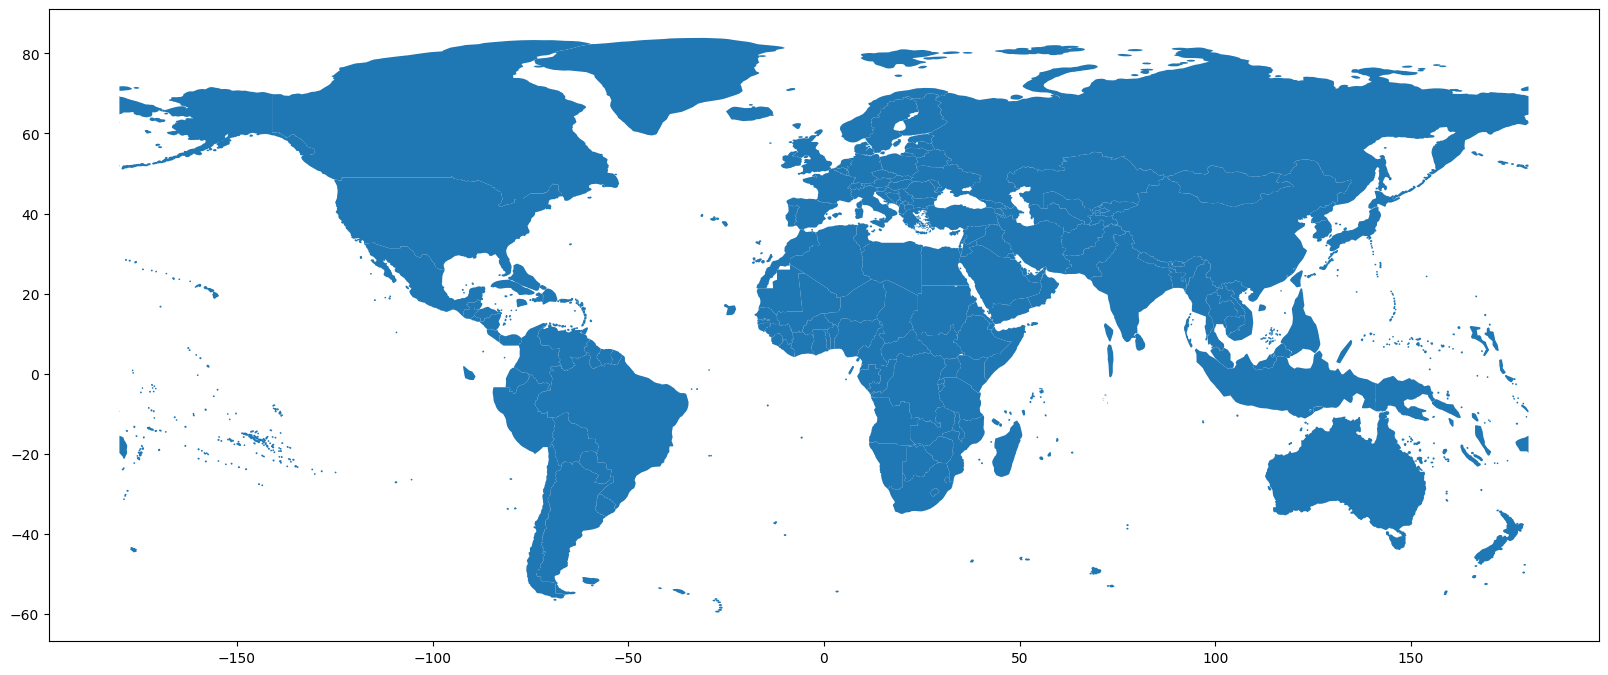

In [8]:
countries.plot(figsize=(20,20))

In [9]:
countries.geom_type.describe()

count              217
unique               1
top       MultiPolygon
freq               217
dtype: object

In [14]:
import json
from tqdm import tqdm

extracts = []

for index in tqdm(range(len(countries))):
    row = countries.iloc[index]
    CC = row['ISO3166-1']
    
    countries.iloc[[index]].to_file(f"extracts/{CC}-borders.geojson")

    extracts.append({
        'output': f'extracts/{CC}.pbf',
        'output_format': 'pbf',
        'description': f"{row['name:en']} / {row['name']}",
        'multipolygon': {
            "file_name": f"extracts/{CC}-borders.geojson",
            "file_type": "geojson"
        }
    })

config = {
    "extracts": extracts
}

fp = open('extracts-config.json', 'wt', encoding='UTF8')
json.dump(config, fp, sort_keys=True, indent=4, ensure_ascii=False)
fp.close()

100%|██████████| 217/217 [00:26<00:00,  8.16it/s]
